# Polybench/AEP Analaysis

The purpose of this notebook is to facilitate the evaluation of the Polybench 3.2 results and their corresponding AEP data.

Note: this customization is for the PMEM1 module data results.


In [1]:
#!/usr/bin/python3

import os
import matplotlib.pyplot as plt
import matplotlib.dates as matdates
#from matplotlib2tikz import save as tikz_save - replaced with new library
import tikzplotlib
import numpy as np
import pandas as pd
from collections import OrderedDict
from cycler import cycler
import math
import statistics

In [2]:
class PolybenchData:
    tests = []

    def __init__(self, log):
        self.log=log # save the name of the file we used
        self.log_name = os.path.basename(self.log)
        self.log_base = os.path.splitext(self.log_name)[0]
    

In [24]:
class AEPWatchData:
    
    per_row = ('epoch', 'timestamp')
    per_entry = ('bytes read', 'bytes written', 'read hit ratio',
            'write hit ratio', 'wdb merge percent',
            'sxp read ops', 'sxp write ops',
            'read 64B ops received', 'write 64B ops received',
            'ddrt read ops', 'ddrt write ops', 'block read ops', 'block write ops')
    linestyles = OrderedDict(
        [('solid',               (0, ())),
         ('loosely dotted',      (0, (1, 10))),
         ('dotted',              (0, (1, 5))),
         ('densely dotted',      (0, (1, 1))),

         ('loosely dashed',      (0, (5, 10))),
         ('dashed',              (0, (5, 5))),
         ('densely dashed',      (0, (5, 1))),

         ('loosely dashdotted',  (0, (3, 10, 1, 10))),
         ('dashdotted',          (0, (3, 5, 1, 5))),
         ('densely dashdotted',  (0, (3, 1, 1, 1))),

         ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
         ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
         ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])

    dimms=[]
    read_hit_ratio = []
    write_hit_ratio = []
    wdb_merge_percentage = []
    sxp_read = []
    sxp_write = []
    ddrt_read = []
    ddrt_write = []

    figdict = {
        # measurement       :  y-label,       column name,          description,                      Derived
        'ddrt read'         : ('operations', 'ddrt read ops',       'CPU read operations (64B)',      False),
        'ddrt write'        : ('operations', 'ddrt write ops',      'CPU write operations (64B)',     False),
        'sxp read ops'      : ('operations', 'sxp read ops',        'Controller read ops (64B)',      False),
        'sxp write ops'     : ('operations', 'sxp write ops',       'Controller write ops (64B)',     False),
        'read hit ratio'    : ('ratio',      'read hit ratio',      'Prefetcher read efficiency',     True),
        'write hit ratio'   : ('ratio',      'write hit ratio',     'Prefetcher write efficiency',    True),
        'write merge ratio' : ('ratio',      'wdb merge percent',   'Write merge efficiency',         True)
        # omitted:
        # cpu bytes read - this is ddrt * 64
        # cpu bytes written - this is ddrt * 64
        # pmem bytes read - this is sxp read ops * 64
        # pmem bytes written - this is sxp write ops * 64
        # read blocks - this is always zero
        # write blocks - this is always zero
    }
        
    
    def __init__(self, log, starting_module=6, ending_module=11):
        self.log=log
        self.log_name = os.path.basename(self.log)
        self.log_base = os.path.splitext(self.log_name)[0]
        self.plot_title = self.log_base[10:self.log_base.find('_')]
        self.columns = [x for x in self.per_row]
        for index in range(0, 12): # our systems have 12 PMEM modules
            self.dimms.append('DIMM{}'.format(index))
            self.ddrt_read.append('ddrt read ops.{}'.format(index))
            self.ddrt_write.append('ddrt write ops.{}'.format(index))
            self.read_hit_ratio.append('read hit ratio.{}'.format(index))
            self.write_hit_ratio.append('write hit ratio.{}'.format(index))
            self.wdb_merge_percentage.append('wdb merge percent.{}'.format(index))
            self.sxp_read.append('sxp read ops.{}'.format(index))
            self.sxp_write.append('sxp write ops.{}'.format(index))
            for e in self.per_entry:
                self.columns.append('{}.{}'.format(e, index))
        self.columns.append('unused')
        self._load_log()
        self.starting_module = starting_module
        self.ending_module = ending_module
        
    def _load_log(self):
        self.aep_data = pd.read_csv(self.log, skiprows=6, sep=';', header=None, names=self.columns)
        self.aep_data = self.aep_data.drop('unused', axis=1) # drop the empty last column       
        return self
    
    def get_aepdata(self):
        return self.aep_data
    
    def get_log_base_name(self):
        return self.log_base
    
    def plot_specific_entry(self, entry_name, output_dir):
        ls_cycle = cycler('linestyle', [AEPWatchData.linestyles[x] for x in AEPWatchData.linestyles])
        linestyle = ls_cycle()
        times = list(self.aep_data['epoch'])
        if len(times) is 0: return # nothing to plot
        timestamps = [t - times[0] for t in times]
        
        plt.style.use('ggplot')
        plt.title(self.plot_title)
        plt.ylabel(self.figdict[entry_name][2], fontsize="x-large")
        plt.xlabel('time (seconds)', fontsize="x-large")
        
        for index in range(self.starting_module, self.ending_module+1):
            plt.plot(timestamps, list(self.aep_data['{}.{}'.format(self.figdict[entry_name][1],index)]),
                    label=self.dimms[index], **next(linestyle), marker='o')

        plt.legend()
        if output_dir is not None:
            en = entry_name.replace(' ', '_')
            plt.savefig('{}/png/{}-{}.png'.format(output_dir, self.plot_title, en))
            plt.savefig('{}/pdf/{}-{}.pdf'.format(output_dir, self.plot_title, en))
            try:
                tikzplotlib.save('{}/tex/{}-{}.tex'.format(output_dir, self.plot_title, en), encoding='utf-8', table_row_sep='\\\\\n')
            except UnicodeEncodeError:
                print('error writing to {}/tex/{}-{}.tex'.format(output_dir, self.plot_title, en))
        plt.show()

    
    def plot_data(self, output_dir=None):
        for entry in self.figdict: self.plot_specific_entry(entry, output_dir)


October 7, 2019
This work is being done for the (revised) CAL paper, so I am only interested in the data for the single PMEM module.  This is present in comerge-pb-results-2019_07_31__01_07_05.

Since this is in a "comerge" subdirectory, it means that the dataset sizes **match** the CoMerge sizes, which makes it useful for the CAL discussion.



In [25]:
class AEPData:

    def __init__(self, dir, filter=None, starting_module=0, ending_module=11):
        self.dir = dir
        if filter: self.aep_logs = [x for x in os.listdir(dir) if x.endswith('.csv') and filter in x]
        else: self.aep_logs = [x for x in os.listdir(dir) if x.endswith('.csv')]
        self.starting_module = starting_module
        self.ending_module = ending_module
        self.aep_data = {}
        self.awd = {}
        self.load_logs()

    def load_logs(self):
        for al in self.aep_logs: 
            resname = os.path.splitext(al)[0]
            self.awd[resname] = AEPWatchData('{}/{}'.format(self.dir, al), 
                                                            starting_module=self.starting_module, 
                                                            ending_module=self.ending_module)
            self.aep_data[resname] = self.awd[resname].get_aepdata()
            #print(self.aep_data[resname])
        return self       


In [26]:
aepdata = AEPData('comerge-pb-results-2019_07_31__01_07_05', 'pmem1', 0, 0)

In [27]:
m_cycle = cycler('marker', AEPWatchData.linestyles)
styles = m_cycle() 


In [28]:
#fig_dir = '{}/{}'.format(os.getcwd(), 'figures/tex')
fig_dir = 'C:\\Users\\TonyMason\\Dropbox (Personal)\\tony\\research\\nvdimm\\paper\\cal\\appendix\\polybench\\aep\\figures\\pmem1'
#fig_dir = '/home/tony/Dropbox/tony/research/nvdimm/paper/cal/appendix/polybench/aep/figures/pmem1'
if os.path.exists(fig_dir): print(fig_dir)
else: fig_dir = None

C:\Users\TonyMason\Dropbox (Personal)\tony\research\nvdimm\paper\cal\appendix\polybench\aep\figures\pmem1


adi


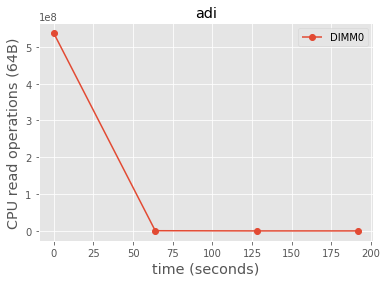

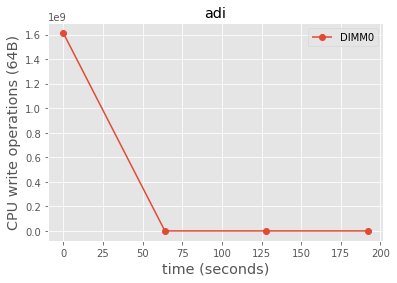

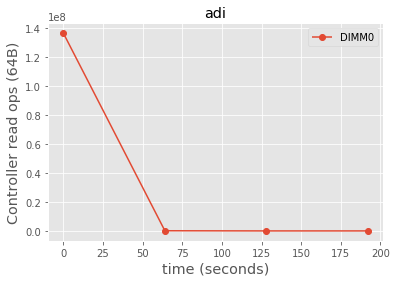

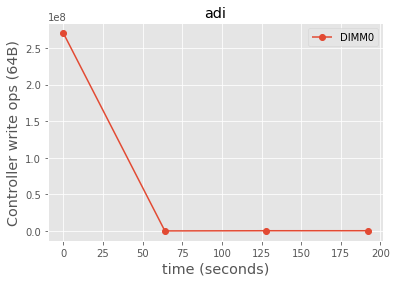

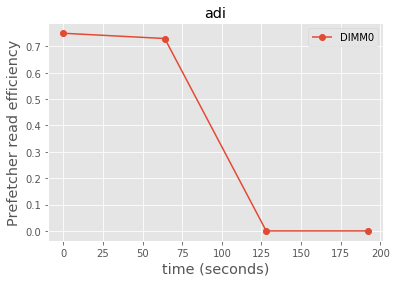

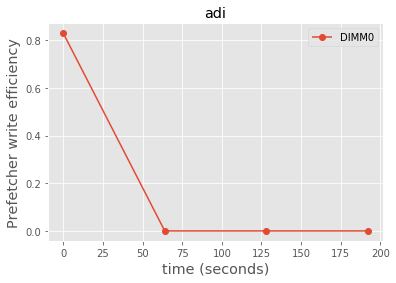

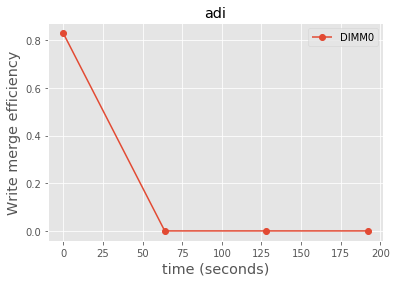

correlation


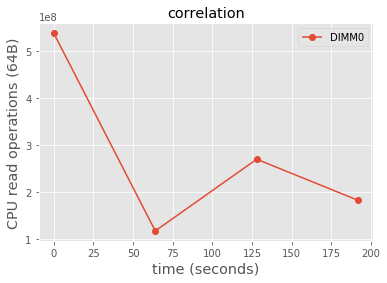

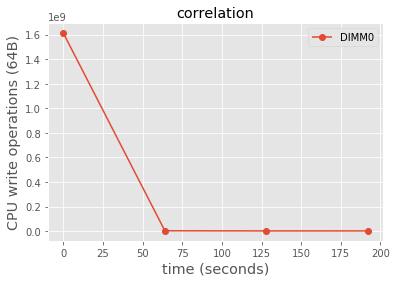

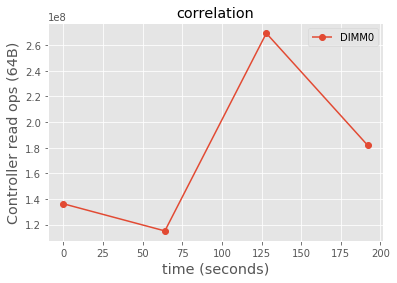

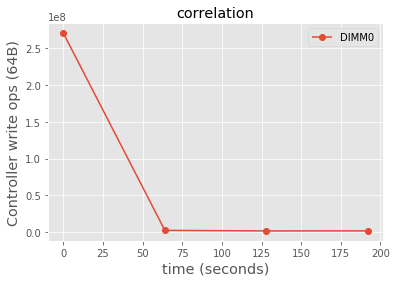

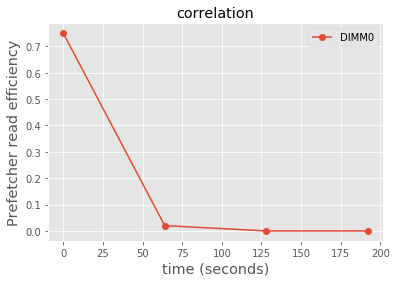

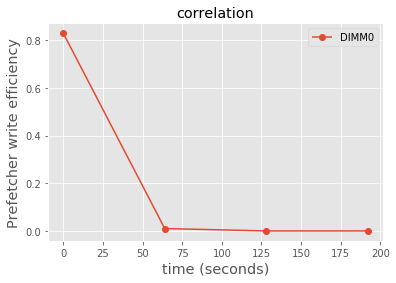

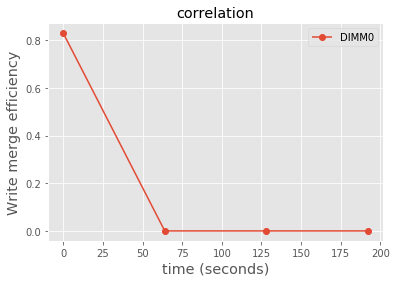

covariance


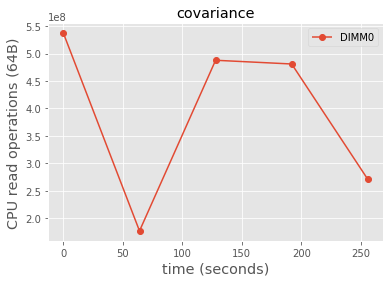

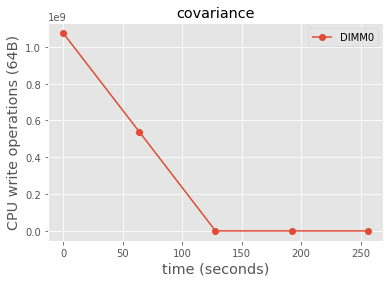

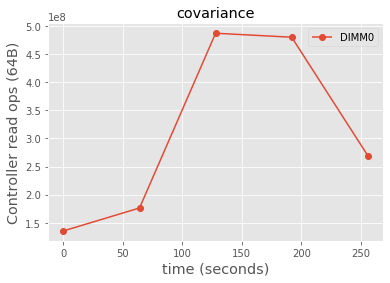

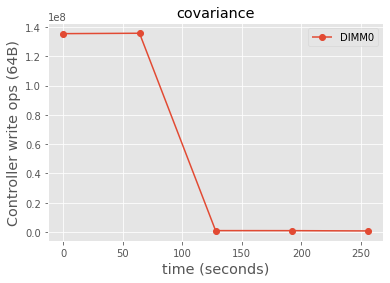

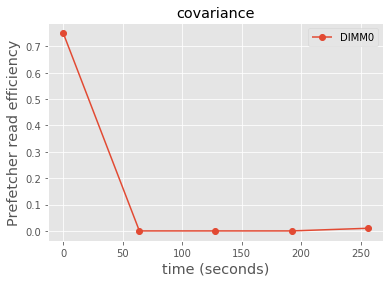

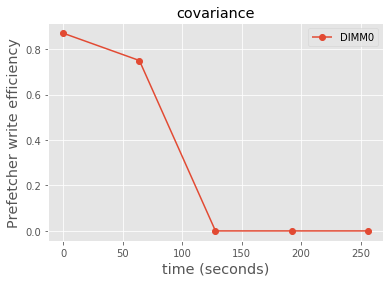

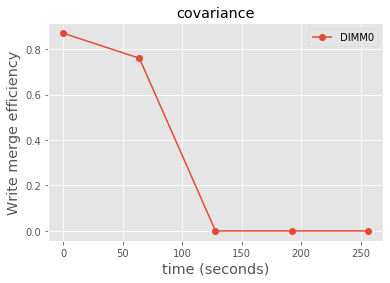

floyd-warshall


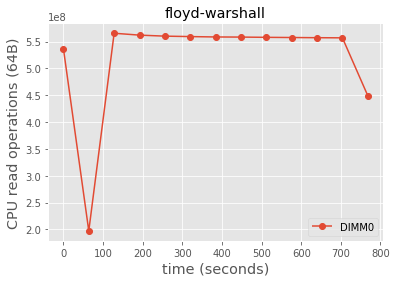

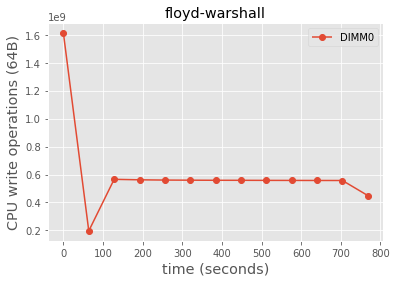

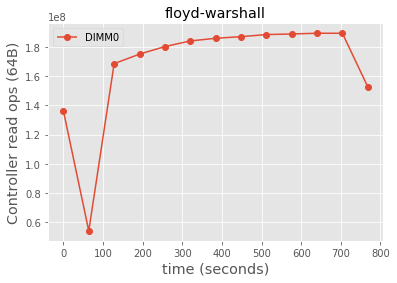

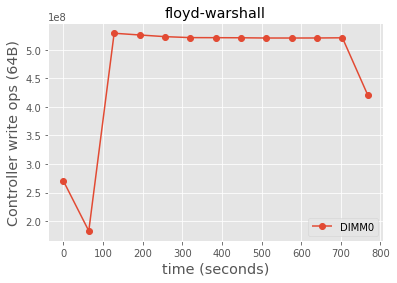

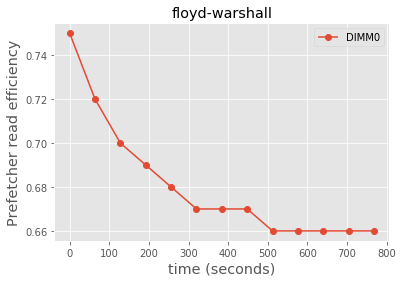

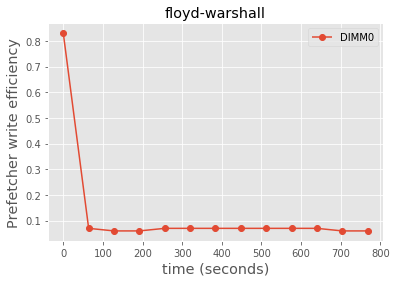

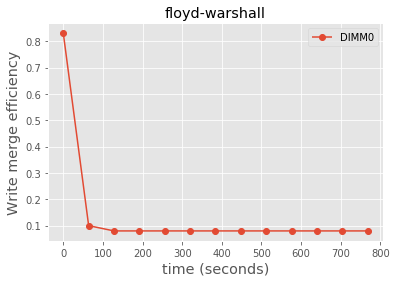

jacobi-1d-imper


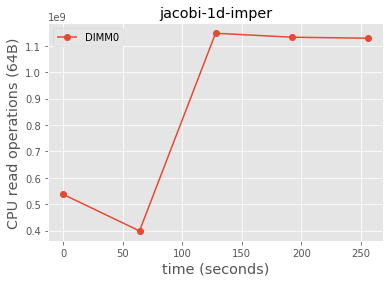

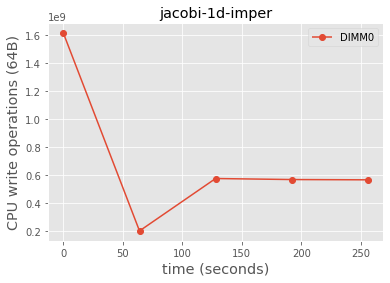

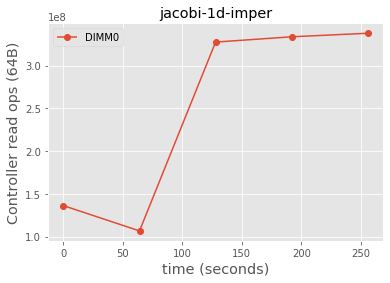

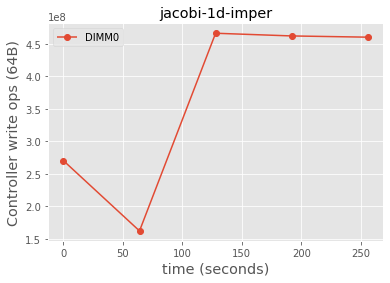

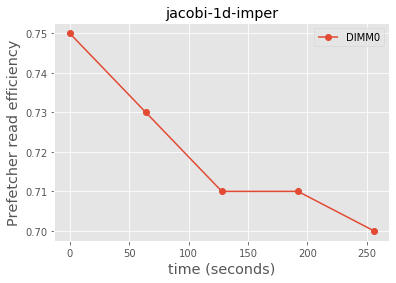

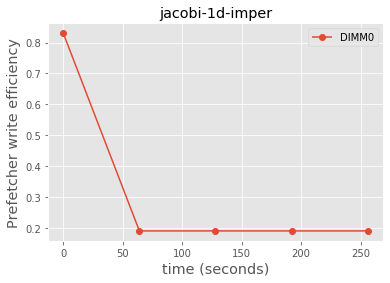

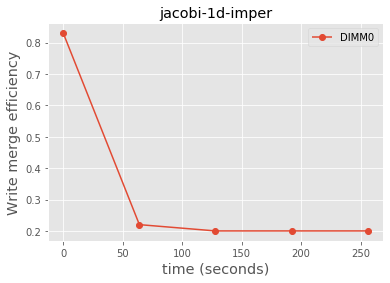

ludcmp


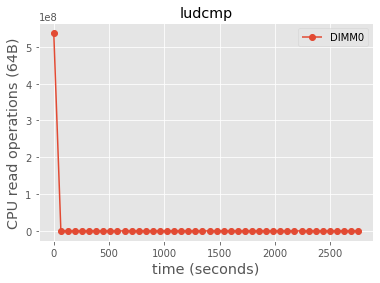

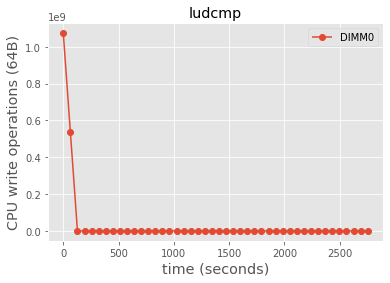

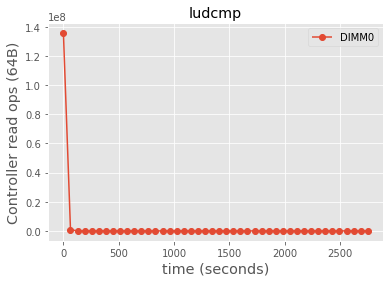

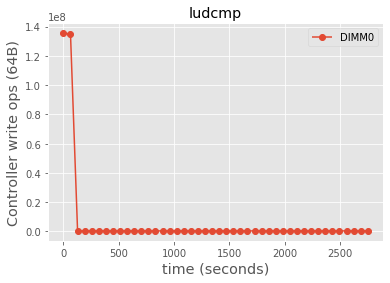

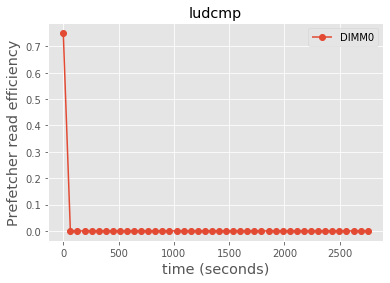

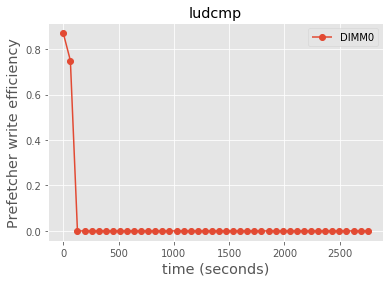

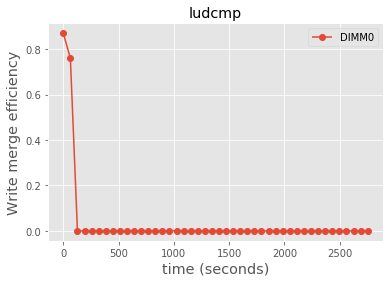

lu


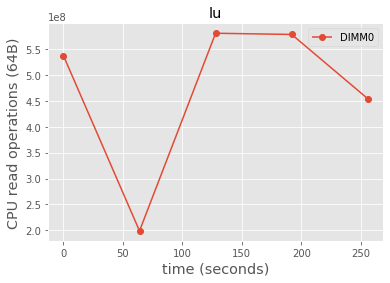

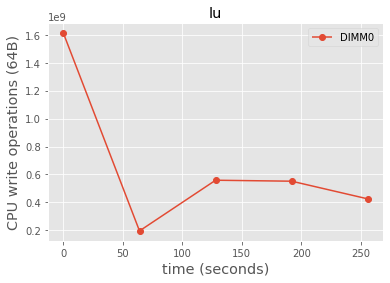

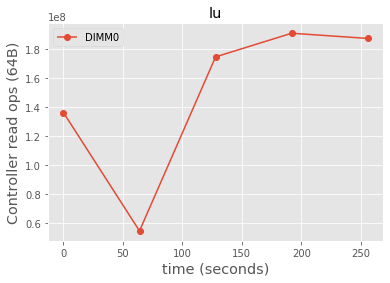

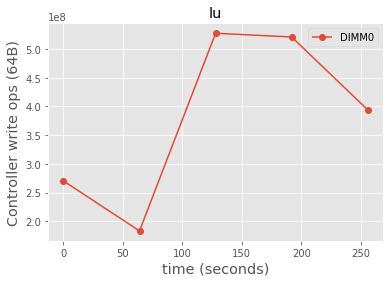

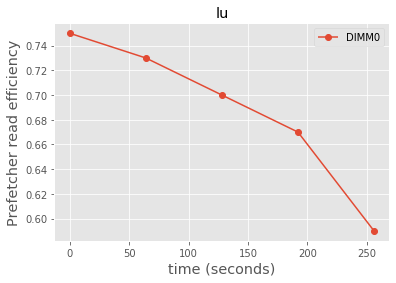

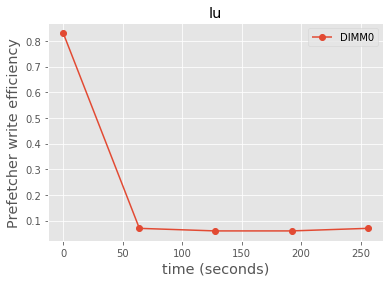

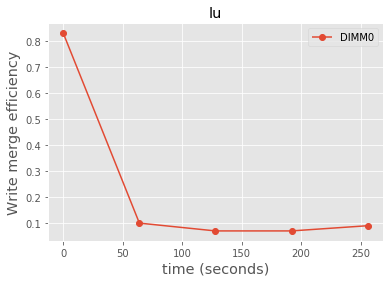

reg


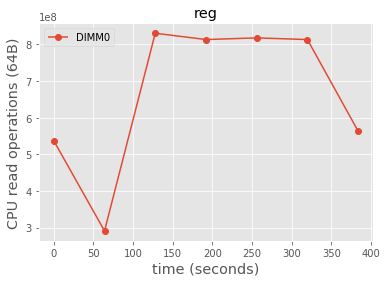

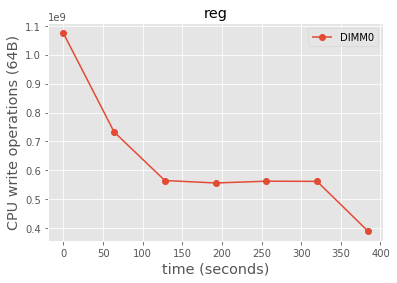

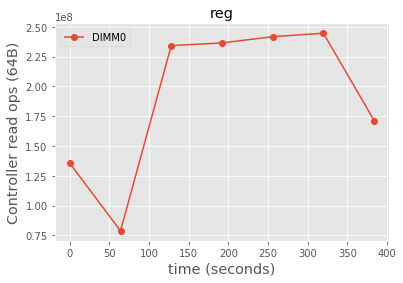

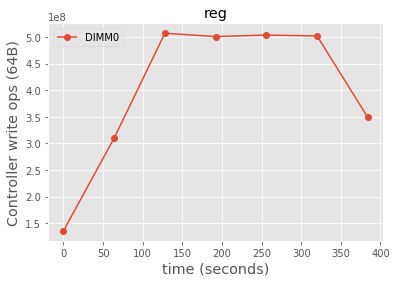

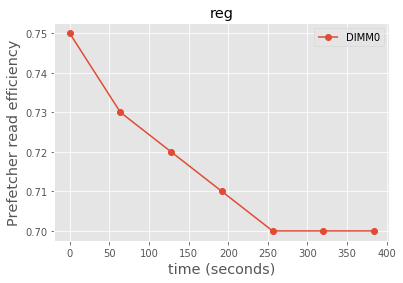

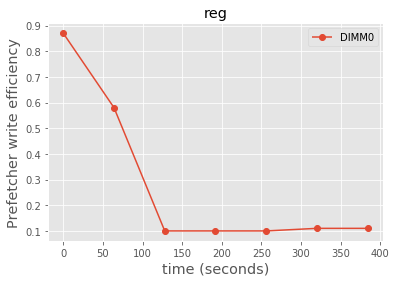

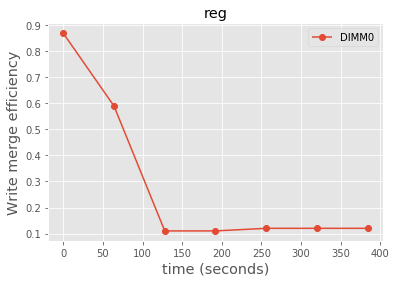

trmm


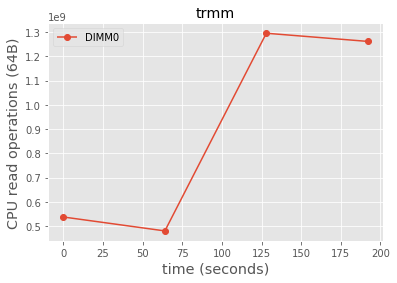

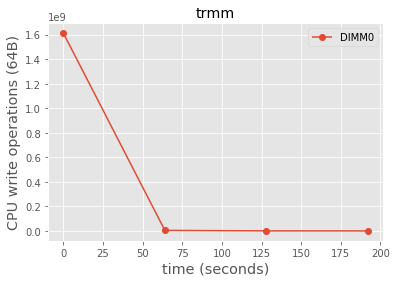

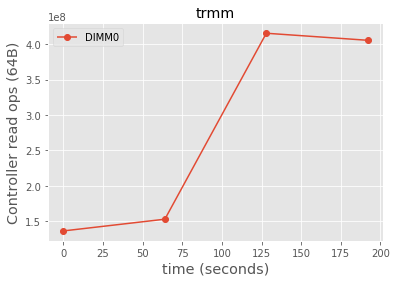

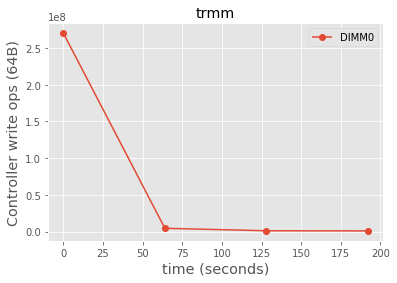

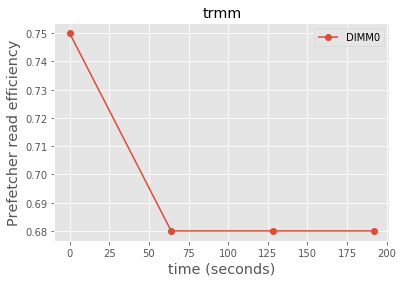

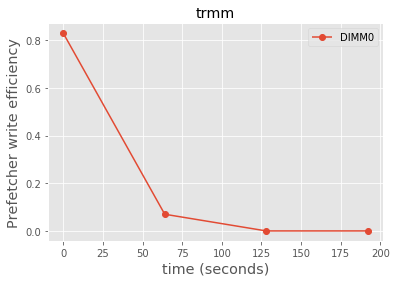

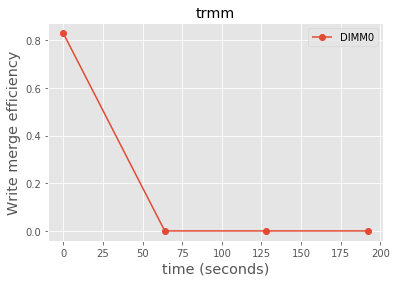

In [29]:
aepdata = AEPData('comerge-pb-results-2019_07_31__01_07_05', 'pmem1', 0, 0)

for rn in aepdata.aep_data:
    if len(aepdata.aep_data[rn]) < 4: continue
    print(aepdata.awd[rn].plot_title)
    aepdata.awd[rn].plot_data(fig_dir)


In [30]:
for rn in aepdata.aep_data:
    for col in aepdata.aep_data[rn].columns: 
        if '.0' in col and 'read' in col and 'ratio' not in col: 
            val = aepdata.aep_data[rn][col][0]
            print('{} = {} - 1/64 = {}, 64x = {}, 1/256 = {}, 256x = {}'.format(col,
                                                                                val,
                                                                                val / 64.0,
                                                                                val * 64.0,
                                                                                val / 256.0,
                                                                                val * 256.0))
    #    if 'read' in col: print(col)
    #print(aepdata.aep_data[rn].columns)
    
    #bytes_read = aepdata.aep_data[rn]['bytes read.0']
    #sxp_read = aepdata.aep_data[rn]['sxp read ops.0']
    #r64_ops = aepdata.aep_data[rn]['read 64B ops received.0']
    #ddrt_read = aepdata.aep_data[rn]['ddrt read ops.0']
    
    # so sxp = 256 byte block count
    # bytes_read * 256 = sxp
    # 
    # print(bytes_read[0] / 256)
    #print(sxp_read[0])
    #print(r64_ops[0]/ddrt_read[0])
    #print(ddrt_read[0])
    
    break

bytes read.0 = 34876677376 - 1/64 = 544948084.0, 64x = 2232107352064.0, 1/256 = 136237021.0, 256x = 8928429408256.0
sxp read ops.0 = 136237021 - 1/64 = 2128703.453125, 64x = 8719169344.0, 1/256 = 532175.86328125, 256x = 34876677376.0
read 64B ops received.0 = 1625792700 - 1/64 = 25403010.9375, 64x = 104050732800.0, 1/256 = 6350752.734375, 256x = 416202931200.0
ddrt read ops.0 = 536971722 - 1/64 = 8390183.15625, 64x = 34366190208.0, 1/256 = 2097545.7890625, 256x = 137464760832.0
block read ops.0 = 0 - 1/64 = 0.0, 64x = 0.0, 1/256 = 0.0, 256x = 0.0


Just to capture this again:

ddrt_read_ops = "number of read operations from the CPU"
ddrt_write_ops = "number of write operations from the CPU"
bytes_read = "number of bytes read from PMEM"
bytes_written = "number of bytes written to PMEM"

So, sxp_{read,written} is derived from bytes_{read,written} (diving by 256)

{read,write}_64B_ops_received is number of read/write operations generated by the memory controller.

The block operations are not used (always zero).

Thus, CPU->MC = "ddrt_read_ops" (operations, multiply by 64 to get bytes)
      MC->PMEM = "read_64b_ops_received" (operations, multiply by 64 to get bytes)




# Let's try to generate compound figures again

In [31]:
#primaryfigs = ('cpu-read-operations', 'cpu-write-operations', 'controller-read-operations', 'controller-write-operations')
fig_dir = 'C:\\Users\\TonyMason\\Dropbox (Personal)\\tony\\research\\nvdimm\\paper\\cal\\appendix\\polybench\\aep\\figures\\pmem1\\tex'
figures = [f for f in os.listdir(fig_dir)]
# manually computed, since the names are potentially complex
figtests = ['adi', 'correlation', 'covariance', 'floyd-warshall', 'jacobi-1d-imper', 'lu', 'ludcmp', 'reg', 'trmm']
testtypes = ['ddrt read', 'ddrt write', 'read hit ratio', 'sxp read ops', 'sxp write ops', 'write hit ratio', 'write merge ratio']

for tt in testtypes:
    if tt not in AEPWatchData.figdict: print ('could not match {}'.format(tt))

primaryfigs = ('ddrt_read', 'ddrt_write', 'sxp_read_ops', 'sxp_write_ops')
rawtexfigs = {pf : [] for pf in primaryfigs}
for fig in figures:
    if not fig.endswith('.tex'): continue
    for pf in primaryfigs:
        if pf in fig: 
            rawtexfigs[pf].append(fig)

def find_ymax(fd):
    y_max = -math.inf
    for line in fd.readlines():
        line = line.strip()
        if 'ymin' in line:
            line=line.split(',')
            assert len(line) >= 2, '{} wrong size'.format(line)
            max = float(line[1].split('=')[1])
            y_max = max
            break
    return y_max

pfmax = {}
for pf in primaryfigs:
    y_max = -math.inf
    for rtf in rawtexfigs[pf]:
        with open('{}/{}'.format(fig_dir, rtf), 'rt') as fd: ymax = find_ymax(fd)
        if ymax > y_max: y_max = ymax
    pfmax[pf] = y_max
    
# find the biggest size
max = 0
for pfm in pfmax: 
    if pfmax[pfm] > max: max = pfmax[pfm]
max = int(1.05 * max) # add some headroom    

ymax_values = []
for pf in primaryfigs:
    for rtf in rawtexfigs[pf]:
        with open('{}/{}'.format(fig_dir, rtf), 'rt') as fd: 
            ymax_values.append(find_ymax(fd))
#print(ymax_values)
ymean = statistics.mean(ymax_values)
ypstdev = statistics.pstdev(ymax_values, ymean)
ypvariance = statistics.pvariance(ymax_values, ymean)
ypmedian = statistics.median(ymax_values)
ypmediang = statistics.median_grouped(ymax_values)
#print(ymean, ypstdev, ypvariance, ypmedian, ypmediang)
#print(ymean + ypstdev, (ymean + ypstdev) / max)
max = float(int(ymean + 2 * ypstdev))

for pfm in pfmax: 
    pfmax[pfm] = max

    
secondaryfigs = ('read_hit_ratio', 'write_hit_ratio', 'write_merge_ratio')
#secondaryfigs = ('prefetcher-read', 'prefetcher-write', 'write-merge')
secondaryrawtexfigs = {sf: [] for sf in secondaryfigs}
for fig in figures:
    if not fig.endswith('.tex'): continue
    for sf in secondaryfigs:
        if sf in fig:
            secondaryrawtexfigs[sf].append(fig)
print(secondaryrawtexfigs)

def write_figure_template(fd, testname):
    if '_' in testname: 
        labelname = testname.replace('_', '-')
        testname = testname.replace('_', '\\_')
    else:
        labelname = testname
    fd.write('\\begin{figure*}[t]\n')
    fd.write('\\captionsetup{justification=centering}\n')
    fd.write('\\centering\n')
    fd.write('\\caption{\\textit{Polybench} Test ')
    fd.write(testname)
    fd.write(' PMEM AEP Activity (see \\S \\ref{sec:evaluation})}')
    fd.write('\\label{fig:aep:')
    fd.write(labelname)
    fd.write('}\n')
    fd.write('\\begin{tabular}{cc|cc|ccc}')
    fd.write('\\multicolumn{7}{c}{\\textit{Polybench}: \\textbf{')
    fd.write(testname)
    fd.write('} (a)-(g)}\n')
    fd.write('\\tabularnewline\n')
    fd.write('\\multicolumn{2}{c|}{\\small CPU to Controller} ')
    fd.write('& \\multicolumn{2}{c|}{\\small Controller to PMEM} ')
    fd.write('& \\multicolumn{3}{c}{\\small Controller Cache}\n')
    fd.write('\\tabularnewline\n')
    fd.write('{\\small Read} & {\\small Write} & ')
    fd.write('{\\small Read} & {\\small Write} & ')
    fd.write('{\\small Read} & {\\small Write} & {\\small Combine}\n')
    fd.write('\\tabularnewline')
    fd.write('(a) & (b) & (c) & (d) & (e) & (f) & (g)\n')
    fd.write('\\tabularnewline\n')
    fd.write('\\resizebox{0.12\\textwidth}{!}{%\n')

def write_figure_content(fd, figurefd, ymax, lastfig=False):
    for line in figurefd.readlines():
        if 'title=' in line:
            fd.write('\t%')
            fd.write(line.strip())
            fd.write('\n')
            continue
        if 'xmin' in line:
            line = line.split(',')
            xmax = float(line[1].split('=')[1])
            fd.write('\txmin=0, xmax={},\n'.format(xmax))
            continue
        if ymax is not None and 'ymin' in line:
            fd.write('\tymin=0, ymax={},\n'.format(ymax))
            continue
        fd.write('\t')
        fd.write(line)
    fd.write('\n}% resizebox\n')
    if not lastfig:
        fd.write('&\n')
        fd.write('\\resizebox{0.12\\textwidth}{!}{%\n')
    
def write_figure_postamble(fd):
    fd.write('%\\tabularnewline\n')
    fd.write('%(h) & (i) & (j) & (k) & (l) & (m) & (n)\n')
    fd.write('\\end{tabular}\n')
    fd.write('\\end{figure*}\n')
    


{'read_hit_ratio': ['adi-read_hit_ratio.tex', 'correlation-read_hit_ratio.tex', 'covariance-read_hit_ratio.tex', 'floyd-warshall-read_hit_ratio.tex', 'jacobi-1d-imper-read_hit_ratio.tex', 'lu-read_hit_ratio.tex', 'ludcmp-read_hit_ratio.tex', 'reg-read_hit_ratio.tex', 'trmm-read_hit_ratio.tex'], 'write_hit_ratio': ['adi-write_hit_ratio.tex', 'correlation-write_hit_ratio.tex', 'covariance-write_hit_ratio.tex', 'floyd-warshall-write_hit_ratio.tex', 'jacobi-1d-imper-write_hit_ratio.tex', 'lu-write_hit_ratio.tex', 'ludcmp-write_hit_ratio.tex', 'reg-write_hit_ratio.tex', 'trmm-write_hit_ratio.tex'], 'write_merge_ratio': ['adi-write_merge_ratio.tex', 'correlation-write_merge_ratio.tex', 'covariance-write_merge_ratio.tex', 'floyd-warshall-write_merge_ratio.tex', 'jacobi-1d-imper-write_merge_ratio.tex', 'lu-write_merge_ratio.tex', 'ludcmp-write_merge_ratio.tex', 'reg-write_merge_ratio.tex', 'trmm-write_merge_ratio.tex']}


In [32]:
out_dir = 'C:\\Users\\TonyMason\\Dropbox (Personal)\\tony\\research\\nvdimm\\paper\\cal\\appendix\\polybench\\aep\\figures\\pmem1'
testfigs=[]
for test in figtests:
    testfig = '{}/{}-pmem1-figure.tex'.format(out_dir, test)
    testfigs.append(testfig)
    with open(testfig, 'wt') as fd:
        write_figure_template(fd, test)
        for pf in primaryfigs: 
            for rtf in rawtexfigs[pf]:
                if '{}-'.format(test) in rtf: 
                    with open('{}/{}'.format(fig_dir, rtf), 'rt') as figfd:
                        ymax = pfmax[pf]
                        write_figure_content(fd, figfd, ymax)
        count = 0
        for sf in secondaryfigs:
            for stf in secondaryrawtexfigs[sf]:
                if '{}-'.format(test) in stf: 
                    with open('{}/{}'.format(fig_dir, stf), 'rt') as figfd:
                        count = count + 1
                        last = count >= len(secondaryfigs)
                        write_figure_content(fd, figfd, 1.0, last)
        write_figure_postamble(fd)



# Unused code beyond this point

In [ ]:
class PolybenchLogData:
    
    run_log_types = ('dram', 'pmem1', 'pmem7')
    make_log_types = ('make',)

   
    class MakeLogData:
        
        pb_options = ('POLYBENCH_TIME',
                      'POLYBENCH_NO_FLUSH_CACHE',
                      'POLYBENCH_LINUX_FIFO_SCHEDULER',
                      'POLYBENCH_CACHE_SIZE_KB', # not really parsing this
                      'POLYBENCH_STACK_ARRAYS',
                      'POLYBENCH_DUMP_ARRAYS',
                      'POLYBENCH_CYCLE_ACCURATE_TIMER',
                      'POLYBENCH_PAPI',
                      'POLYBENCH_USE_C99_PROTO',
                      'POLYBENCH_USE_SCALAR_LB',
                      )
        
        pb_datasets = ('MINI_DATASET', 
                       'SMALL_DATASET', 
                       'STANDARD_DATASET', 
                       'LARGE_DATASET',
                       'EXTRALARGE_DATASET',
                       )
        
        def __init__(self, makelog):
            self.makelog = makelog
            assert 'make' in makelog, "Unknown make log type {}".format(makelog)
            self.label = 'make'
            self.file_data = None
            self.options = {x : False for x in self.pb_options}
            self.dataset = self.pb_datasets[2]
            self.load_file()
            self.parse_options()
            assert not self.options['POLYBENCH_CACHE_SIZE_KB'], "Not handling this option"

        def label(self):
            '''Return the log data label'''
            return self.label
        
        def load_file(self):
            '''Load the makefile log'''
            with open(self.makelog, 'r') as fd:
                self.file_data = fd.readlines()
            return self
        
        def parse_options(self):
            """Scan the Make log to find the build options"""
            assert self.file_data is not None, "File data not loaded"
            #print(self.file_data[0])
            for line in self.file_data:
                for option in self.pb_options:
                    if option in line:
                        self.options[option] = True
                for ds in self.pb_datasets:
                    if ds in line: self.dataset = ds
            #print(self.options)
            #print(self.dataset)
            return self
        
        def get_options(self):
            """Get a list of the options for this Make log"""
            return [x for x in self.options if self.options[x]]
        
        def get_all_options(self):
            """Get a true/false list of the options present"""
            return self.options
        
        def get_dataset(self):
            """Get the data set used"""
            return self.dataset
                        
                
    class RunLogData:

        results_labels = ('Test', 'Allocation', 'Ticks')
        
        def __init__(self, runlog):
            self.runlog = runlog
            if 'dram' in runlog:
                self.label = 'dram'
            elif 'pmem1' in runlog:
                self.label = 'pmem1'
            elif 'pmem7' in runlog:
                self.label = 'pmem7'
            else: assert False, "Unknown run log type {}".format(runlog)
            self.log_data = []
            self.results = []
            self.load_file()
            self.parse_log()
            
                
        def label(self):
            """Get the dataset label"""
            return self.label
        
        
        def load_file(self):
            """Load the run log data"""
            # print(self.runlog)
            with open(self.runlog, 'r+t') as fd:
                self.log_data = fd.readlines()
            return self
        
        def parse_log(self):
            # print(self.runlog)
            #print(self.log_data[0])
            index = 0
            while index < len(self.log_data):
                test = self.log_data[index]
                index = index + 1
                alloc = []
                while 'allocate' in self.log_data[index]:
                    alloc.append(self.log_data[index])
                    index = index + 1
                ticks = int(self.log_data[index])
                index = index + 1
                # at this point we have data for one test run
                test = test.split('/')[-1].strip()[:-5]
                total_size = 0
                for al in alloc:
                    alloc_size = int(al.split(' ')[-1].strip())
                    total_size = total_size + alloc_size
                #print(ticks)
                self.results.append((test, total_size, ticks))
            #print(self.results)
            return self
          
        def get_results(self):
            return self.results
            
    
    class AEPData:
        
        def __init__(self, dir):
            self.dir = dir
            self.aep_logs = [x for x in os.listdir(dir) if x.endswith('.csv')]
            self.aep_data = {}
            self.load_logs()
            
        def load_logs(self):
            for al in self.aep_logs: 
                resname = os.path.splitext(al)[0]
                awd = AEPWatchData('{}/{}'.format(self.dir, al))
                self.aep_data[resname] = awd.get_aepdata()
                #print(self.aep_data[resname])
            return self       
 
                                                      
    def __init__(self, dir='.'):
        self.dir = dir
        self.start = 0
        self.logs = [x for x in os.listdir('.') if 'runall' in x and x.endswith('.log')]
        #print(self.logs)
        self.runlogs = {}
        for l in self.logs:
            lt = os.path.splitext(l)[0]
            lts = lt.split('-')
            lt = '{}-{}'.format(lts[1], lts[-1])
            self.runlogs[lt] = (l, self.parse_logs(l))
        #print(self.runlogs)
        self.dataframe = self.get_dataframe()

    def __iter__(self):
        return (self.runlogs[rl] for rl in self.runlogs)
            
    def load_logs(self, dir):
        logs = [x for x in os.listdir(dir) if x.endswith('.log')]
        return logs


    def parse_logs(self, log):
        runs = []
        with open(log) as fd:
            for line in fd.readlines():
                data={}
                if 'mkdir' not in line: continue # skip
                line = line.strip().split(' ')
                log_dir = line[1]
                logs = self.load_logs(log_dir) # second parameter is what directory we made
                #print(logs[0].split('-'))
                for l in logs:
                    found = False
                    for rlt in self.run_log_types:
                        if rlt in l: 
                            data[rlt] = self.RunLogData('{}/{}'.format(log_dir,l))
                            found = True
                            break
                    if found: continue
                    assert len(self.make_log_types) 
                    #print(self.make_log_types)
                    for mlt in self.make_log_types:
                        if mlt in l:
                            data[mlt] = self.MakeLogData('{}/{}'.format(log_dir,l))
                            found = True
                            break
                    if found: continue
                    assert False, "Unknown log type {}".format(l)
                runs.append(data)
                self.aepdata = self.AEPData(log_dir)
        return runs
        #print(runs)

        
    def load_log_data(label, log):
            with open(log, 'r') as fd:
                self.logdata[label] = readlines()
            return self
        
    def get_dataset_types(self):
        return (self.MakeLogData.pb_datasets)
    
    def get_pb_options(self):
        return (self.MakeLogData.pb_options)

    def get_log_types(self):
        return (self.run_log_types)
    
    def get_make_log_types(self):
        return (self.make_log_types)
    
    def get_dataframe(self):
        """Return dataframe"""
        if getattr(self, 'dataframe', None) is not None: return self.dataframe
        optlist_labels = [opt for opt in self.get_pb_options()]
        labels = ['Timestamp', 'Run', 'Dataset', 'Type']
        labels = labels + optlist_labels
        labels = tuple(labels + ['Test', 'Alloc', 'Ticks'])
        flat_data = []
        for rl in self.runlogs:
            _, results = self.runlogs[rl]
            timestamp, run = os.path.splitext(rl)[0].split('-')
            for res in results:
                dataset = res['make'].get_dataset()
                options = res['make'].get_all_options()
                optlist = [options[opt] for opt in optlist_labels]
                for lt in self.get_log_types():
                    for tests in res[lt].get_results():
                        data = [timestamp, int(run), dataset, lt] + optlist
                        test, alloc, ticks = tests
                        data = tuple(data + [test, alloc, ticks])
                        flat_data.append(data)
                        assert len(data) == len(labels), \
                            "Label count {} doesn't match data length {}".format(len(labels), len(data))
        self.dataframe = pd.DataFrame(flat_data, columns = labels) 
        return self.dataframe

logdata = PolybenchLogData()



In [ ]:
print(logdata.logs)

In [ ]:
# print(logdata.get_dataframe())

import statistics
from scipy.stats.mstats import gmean

df = logdata.get_dataframe()

def select_data(df, Dataset='EXTRALARGE_DATASET', Type='dram', Test='2mm'):
    return df.loc[(df['Dataset'] == Dataset) & (df['Type'] == Type) & (df['Test'] == Test)]

average_data = []
average_data_labels = ('Test', 'Dataset', 'Type', 'Alloc', 'Mean', 
                       'Harmonic Mean', 'Geometric Mean', 'Standard Deviation')
for test in df['Test'].unique():
    for d in df['Dataset'].unique():
        for t in df['Type'].unique():
            data = select_data(df, d, t, test)
            ticks = list(data['Ticks'])
            alloc = statistics.mean(list(data['Alloc']))
            ticks_mean = statistics.mean(ticks)
            ticks_hmean = statistics.harmonic_mean(ticks)
            ticks_gmean = gmean(ticks)
            ticks_stdev = statistics.stdev(ticks, ticks_mean)
            average_data.append((test, d, t, alloc, ticks_mean, ticks_hmean, ticks_gmean, ticks_stdev))

average_df = pd.DataFrame(average_data, columns=average_data_labels)

dram_baseline = average_df.loc[average_df['Type'] == 'dram']
#print(dram_baseline)
dram_value = average_df.loc[(average_df['Test'] == '3mm') & 
                            (average_df['Dataset'] == 'EXTRALARGE_DATASET') &
                            (average_df['Type'] == 'dram')]
#print(dram_value)
#print(list(average_df['Mean']))
#print(len(average_data))
normalized_mean = []
normalized_hmean = []
normalized_gmean = []
for index in range(len(average_data)):
    row = average_df.iloc[index,:]
    #print(row['Mean'])
    dram_value = average_df.loc[(average_df['Test'] == row['Test']) & 
                                (average_df['Dataset'] == row['Dataset']) &
                                (average_df['Type'] == 'dram')]
    #print(list(dram_value['Mean'])[0])
    nmean = row['Mean'] / list(dram_value['Mean'])[0]
    normalized_mean.append(nmean)
    hmean = row['Harmonic Mean'] / list(dram_value['Harmonic Mean'])[0]
    normalized_hmean.append(hmean)
    gmean = row['Geometric Mean'] / list(dram_value['Geometric Mean'])[0]
    normalized_gmean.append(gmean)
#print(len(normalized_mean), normalized_mean)
#print(len(normalized_hmean), normalized_hmean)
#print(len(normalized_gmean), normalized_gmean)
average_df['Normalized Mean'] = normalized_mean
average_df['Normalized Harmonic Mean'] = normalized_hmean
average_df['Normalized Geometric Mean'] = normalized_gmean
#print(average_df)

pmem1_faster = average_df.loc[(average_df['Normalized Mean'] < 1.0) & (average_df['Type'] == 'pmem1')]
print(pmem1_faster)
pmem7_faster = average_df.loc[(average_df['Normalized Mean'] < 1.0) & (average_df['Type'] == 'pmem7')]
print(pmem7_faster)
pmem1_slower = average_df.loc[(average_df['Normalized Mean'] > 1.0) & (average_df['Type'] == 'pmem1')]
print(pmem1_slower)
pmem7_slower = average_df.loc[(average_df['Normalized Mean'] > 1.0) & (average_df['Type'] == 'pmem7')]
print(pmem7_slower)
#print(len(df['Test'].unique()))



#print(df.loc[(df['Dataset'] == 'LARGE_DATASET') & (df['Type'] == 'dram')])
#ticks = select_data(df)['Ticks']
#ticks_mean = statistics.mean(ticks)
#ticks_hmean = statistics.harmonic_mean(ticks)
#ticks_gmean = gmean(ticks)
#ticks_stdev = statistics.stdev(ticks, ticks_mean)
#print(ticks_mean)
#print(ticks_hmean)
#print(ticks_gmean)
#print(ticks_stdev)
#print(ticks_stdev/ticks_mean)



In [ ]:
optlist_labels = [opt for opt in logdata.get_pb_options()]
labels = ['Timestamp', 'Run', 'Dataset', 'Type']
labels = labels + optlist_labels
labels = tuple(labels + ['Test', 'Alloc', 'Ticks'])
#print(labels)

flat_data = []
for run, results in logdata:
    _, timestamp, _, run = os.path.splitext(run)[0].split('-')
    for res in results:
        dataset = res['make'].get_dataset()
        options = res['make'].get_all_options()
        optlist = [options[opt] for opt in optlist_labels]
        for lt in logdata.get_log_types():
            for tests in res[lt].get_results():
                data = [timestamp, int(run), dataset, lt] + optlist
                test, alloc, ticks = tests
                data = tuple(data + [test, alloc, ticks])
                flat_data.append(data)
                assert len(data) == len(labels), \
                    "Label count {} doesn't match data length {}".format(len(labels), len(data))
# print(flat_data)

df = pd.DataFrame(flat_data, columns = labels) 
print(df)

In [ ]:
datasets = {}
for run, rundata in logdata:
    for index in range(len(rundata)):
        dst = rundata[index]['make'].get_dataset()
        if dst not in datasets: datasets[dst] = {}
        for lt in logdata.get_log_types():
            if lt in rundata[index]:
                if lt not in datasets[dst]: datasets[dst][lt] = []
                datasets[dst][lt].append(rundata[index][lt])

merged_data = {ds : {} for ds in datasets}
for ds in datasets:
    merged_data[ds] = {lt: {} for lt in datasets[ds]}
    for lt in datasets[ds]:
        for results in datasets[ds][lt]:
            total_results = merged_data[ds][lt]
            for res in results.get_results():
                test, size, ticks = res
                if test not in total_results:
                    total_results[test] = {'size': 0, 'ticks': 0, 'count': 0}
                total_results[test]['size'] = total_results[test]['size'] + size
                total_results[test]['ticks'] = total_results[test]['ticks'] + ticks
                total_results[test]['count'] = total_results[test]['count'] + 1
            merged_data[ds][lt] = total_results

average_data = {ds : {} for ds in merged_data}
for ds in merged_data:
    average_data[ds] = {lt: {} for lt in merged_data[ds]}
    for lt in merged_data[ds]:
        average_data[ds][lt] = {}
        for test in merged_data[ds][lt]:
            results = merged_data[ds][lt][test]
            size = results['size'] / results['count']
            ticks = float(results['ticks']) / float(results['count'])
            average_data[ds][lt][test] = {'size' : size, 'ticks' : ticks}
            
# create a flat version of this data
flat_data = []
for ds in average_data:
    for lt in average_data[ds]:
        for test in average_data[ds][lt]:
            size = average_data[ds][lt][test]['size']
            ticks = average_data[ds][lt][test]['ticks']
            flat_data.append((ds, lt, test, size, ticks))
            
print(flat_data)
#for run, rundata in logdata:
#    print(run)
#    for index in range(len(rundata)):
#        datasets[rundata[index]['make'].get_dataset()].append(rundata)

#for ds in datasets: print(datasets[ds])

    
#for lt in PolybenchLogData.run_log_types:
#    print(lt)

In [ ]:

def print_test_size(df, test, size):
    sd = select_data(df, Dataset=size, Type='dram', Test=test)
    try:
        return (test, size, int(sd['Alloc']))
    except Exception as e:
        print('failed with {} ({}): {}'.format(test, size, sd['Alloc']))
    return (test, size, 0)

comerge_map = [
    ('gramschmidt', 'LARGE_DATASET'),
    ('correlation', 'EXTRALARGE_DATASET'),
    ('mvt', 'EXTRALARGE_DATASET'),
    ('gemm', 'LARGE_DATASET'),
    ('symm', 'LARGE_DATASET'),
    ('fdtd-2d', 'EXTRALARGE_DATASET'),
    ('gemver', 'EXTRALARGE_DATASET'),
    ('durbin', 'EXTRALARGE_DATASET'),
    ('trisolv', 'EXTRALARGE_DATASET'),
    ('adi', 'EXTRALARGE_DATASET'),
    ('atax', 'EXTRALARGE_DATASET'),
    ('fdtd-apml', 'LARGE_DATASET'),
    ('seidel-2d', 'EXTRALARGE_DATASET'),
    ('doitgen', 'LARGE_DATASET'),
    ('ludcmp', 'LARGE_DATASET'),
    ('bicg', 'LARGE_DATASET'),
    ('syr2k', 'LARGE_DATASET'),
    ('3mm', 'LARGE_DATASET'),
    ('cholesky', 'EXTRALARGE_DATASET'),
    ('jacobi-2d-imper', 'EXTRALARGE_DATASET'),
    ('syrk', 'LARGE_DATASET'),
    ('gesummv', 'EXTRALARGE_DATASET'),
    ('trmm', 'EXTRALARGE_DATASET'),
    ('floyd-warshall', 'EXTRALARGE_DATASET'),
    ('covariance', 'STANDARD_DATASET'),
    ('2mm', 'LARGE_DATASET'),
    ('dynprog', 'LARGE_DATASET'),
    ('lu', 'LARGE_DATASET'),
    ('reg_detect', 'LARGE_DATASET'),
    ('jacobi-1d-imper', 'EXTRALARGE_DATASET'),
]

print(len(comerge_map))

def convert_size(size):
    original_size = size
    size = float(size)
    map = ['B', 'KB', 'MB', 'GB', 'TB', 'PB', 'EB', 'ZB', 'YB']
    bound = 1024
    for index in range(len(map)):
        if size < bound:
            return (size, map[index])
        size = size / bound
    return (original_size, map[0])

for cm in comerge_map:
    test, size, alloc = print_test_size(average_df, cm[0], cm[1])
    alloc_value, alloc_units = convert_size(alloc)
    print('{} ({}): {} -> {:.1f}{}'.format(test, size, alloc, alloc_value, alloc_units))

#print(print_test_size(average_df, 'gramschmidt', 'LARGE_DATASET'))

test_sizes = [1024**index for index in range(10)]
print(test_sizes)
for t in test_sizes:
    print('{} -> {}', t, convert_size(t))


In [ ]:
# print(average_df)
datasize = {}
for cm in comerge_map:
    for dset in ('SMALL_DATASET', 'STANDARD_DATASET', 'LARGE_DATASET', 'EXTRALARGE_DATASET'):
        test, size, alloc = print_test_size(average_df, cm[0], dset)
        assert size == dset, 'Returned size {} does not match requested size {}'.format(size, dset)
        if test not in datasize: datasize[test] = {}
        alloc_value, alloc_units = convert_size(alloc)
        datasize[test][size] = '{:.1f}{}'.format(alloc_value, alloc_units)

print('{:10}\t{:10}\t{:10}\t{:10}\t{}'.format('Test', 'Small', 'Standard', 'Large', 'Extra Large'))
for test in datasize: 
    print('{:10}\t{:10}\t{:10}\t{:10}\t{}'.format(test,
                                        datasize[test]['SMALL_DATASET'],
                                        datasize[test]['STANDARD_DATASET'],
                                        datasize[test]['LARGE_DATASET'],
                                        datasize[test]['EXTRALARGE_DATASET']                                        
                                       ))



One of the open questions has been "why do the values for some of these deviate from what I measure using the _standard_ Polybench suite?"

So first, let's walk through and identify those that do match:

gramschmidt - Matches LARGE_DATASET
gemm - Matches LARGE_DATASET
symm - Matches LARGE_DATASET
fdtd-apml - Matches STANDARD_DATASET
syr2k - Matches LARGE_DATASET
cholesky - Matches EXTRA_LARGE
trmm - Matches EXTRA_LARGE
floyd-warshall - Matches EXTRA_LARGE
lu - Matches EXTRA_LARGE

correlations - CoMerge has 137.4MB - found the header file sizes were changed.
mvt - CoMerge has 1.7GB - found the header file sizes were changed.
fdtd-2d - CoMerge has 1.4GB - found the header file sizes were changed.
gemver - CoMerge has 1.7GB - found the header file sizes were changed.
durbin - CoMerge has 1.5GB
trisolv -
adi - 
atax - 
seidel-2d -
doitgen - 
ludcmp - 
bicg - 
3mm - 
jacobi-2d-imper - 
syrk - 
gesummv -
covariance - 
2mm - 
dynprog - 
reg_detect - 
jacobi-1d-imper -



In [ ]:
# mvt, direct from trace: print(sum([512000000,64000,64000,64000,64000]))
# this isn't 372.5GB
size = sum([80000000000,800000,800000,800000,800000])
print(convert_size(size))
print(convert_size(400000000000))
mvt_data = select_data(df, Dataset='EXTRALARGE_DATASET', Type='dram', Test='mvt')

print(mvt_data)


# Code beyond this point is not used in this notebook

I have left it here for reference

In [ ]:
data_set_sizes = ('extra large', 'large', 'standard', 'small')

def load_run_logs(dir):
    logs = [x for x in os.listdir(dir) if x.endswith('.log')]
    return logs

def parse_make_log(makelog):
    print(makelog)
    
def parse_data_log(datalog):
    print(datalog)

def load_runall_log(log):
    runs = []
    with open(log) as fd:
        for line in fd.readlines():
            data={}
            if 'mkdir' not in line: continue # skip
            line = line.strip().split(' ')
            logs = load_run_logs(line[1]) # second parameter is what directory we made
            print(logs[0].split('-'))
            for l in logs:
                if 'dram' in l: data['dram'] = l
                elif 'pmem1' in l: data['pmem1'] = l
                elif 'pmem7' in l: data['pmem7'] = l
                elif 'make' in l: data['make'] = l
                else: assert False, "Unknown log type {}".format(l)
            runs.append(data)
    return runs




In [ ]:
pb_results_dirs = [x for x in os.listdir('.') if 'pb-results' in x]
pb_results = {}
for rd in pb_results_dirs:
    aep_logs = [x for x in os.listdir(rd) if 'aep-' in x]
    pb_logs = [x for x in os.listdir(rd) if x.endswith('.log')]
    pb_results[rd] = {'aep' : aep_logs, 'logs': pb_logs}


In [ ]:
'''
Default Format
timestamp;;DIMM0;;;;;;;;;;;;;DIMM1;;;;;;;;;;;;;DIMM2;;;;;;;;;;;;;DIMM3;;;;;;;;;;;;;DIMM4;;;;;;;;;;;;;DIMM5;;;;;;;;;;;;;DIMM6;;;;;;;;;;;;;DIMM7;;;;;;;;;;;;;DIMM8;;;;;;;;;;;;;DIMM9;;;;;;;;;;;;;DIMM10;;;;;;;;;;;;;DIMM11;;;;;;;;;;;;;
epoch;timestamp;bytes_read (derived);bytes_written (derived);read_hit_ratio (derived);write_hit_ratio (derived);wdb_merge_percent (derived);sxp_read_ops (derived);sxp_write_ops 
'''
columns = ['column 1', 'column 2']
per_entry = ('epoch', 'timestamp', 'bytes read', 'bytes written', 'read hit ratio',
        'write hit ratio', 'wdb merge percent',
        'sxp read ops', 'sxp write ops',
        'read 64B ops received', 'write 64B ops received',
        'ddrt read ops', 'ddrt write ops')
for index in range(0,12):
    dimm_label='DIMM{}'.format(index)
    for e in per_entry:
        columns.append('{}:{}'.format(dimm_label, e))
columns.append('unused')

gs_data = pd.read_csv("log.csv", skiprows=6, sep=';', header=None, names=columns)
gs_data.drop('unused', axis=1)

data = {}
for index in range(0,12):
    dimm_label = 'DIMM{}'.format(index)
    start = 2 + (index * len(per_entry))
    end = 2 + ((index + 1) * len(per_entry))
    data[dimm_label] = gs_data.iloc[:, start:end]
    data[dimm_label].columns = list(per_entry)
    data[dimm_label].sort_values(by='timestamp', kind='mergesort', ascending=True,inplace=True)
    data[dimm_label]

def plot_specific_entry(data, test_name, entry_name):
    plt.style.use("ggplot")
    plt.title('{} {}'.format(test_name, entry_name))
    seclocator = matdates.SecondLocator(bysecond=[30]) 
    minlocator = matdates.MinuteLocator(byminute=range(60))  # range(60) is the default
    majorFmt = matdates.DateFormatter('%Y-%m-%d, %H:%M:%S')  
    minorFmt = matdates.DateFormatter('%H:%M:%S')
    for dimm in range(6,12):
        dimm_label = 'DIMM{}'.format(dimm)
        timestamps = data[dimm_label]['timestamp']
        plt.plot(data[dimm_label]['timestamp'], data[dimm_label][entry_name], label=dimm_label)
        # print(data[dimm_label][entry_name])
    plt.legend()
    plt.show()

for index in range(2, len(per_entry)):
    plot_specific_entry(data, 'ranjan', per_entry[index])


In [ ]:
logdir = 'aepwatch_logs'
logs = ['{}/{}'.format(logdir, x) for x in os.listdir('aepwatch_logs')]
print(logs)

In [ ]:
class AEPWatchData:
    
    per_row = ('epoch', 'timestamp')
    per_entry = ('bytes read', 'bytes written', 'read hit ratio',
            'write hit ratio', 'wdb merge percent',
            'sxp read ops', 'sxp write ops',
            'read 64B ops received', 'write 64B ops received',
            'ddrt read ops', 'ddrt write ops', 'block read ops', 'block write ops')
    linestyles = OrderedDict(
        [('solid',               (0, ())),
         ('loosely dotted',      (0, (1, 10))),
         ('dotted',              (0, (1, 5))),
         ('densely dotted',      (0, (1, 1))),

         ('loosely dashed',      (0, (5, 10))),
         ('dashed',              (0, (5, 5))),
         ('densely dashed',      (0, (5, 1))),

         ('loosely dashdotted',  (0, (3, 10, 1, 10))),
         ('dashdotted',          (0, (3, 5, 1, 5))),
         ('densely dashdotted',  (0, (3, 1, 1, 1))),

         ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
         ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
         ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])   

    dimms=[]
    read_hit_ratio = []
    write_hit_ratio = []
    wdb_merge_percentage = []
    sxp_read = []
    sxp_write = []
    ddrt_read = []
    ddrt_write = []

    figdict = {
        # measurement       :  y-label,       column name,          description,                      Derived
        'ddrt read'         : ('operations', 'ddrt read ops',       'CPU read operations (64B)',      False),
        'ddrt write'        : ('operations', 'ddrt write ops',      'CPU write operations (64B)',     False),
        'sxp read ops'      : ('operations', 'sxp read ops',        'Controller read ops (64B)',      False),
        'sxp write ops'     : ('operations', 'sxp write ops',       'Controller write ops (64B)',     False),
        'read hit ratio'    : ('ratio',      'read hit ratio',      'Prefetcher read efficiency',     True),
        'write hit ratio'   : ('ratio',      'write hit ratio',     'Prefetcher write efficiency',    True),
        'write merge ratio' : ('ratio',      'wdb merge percent',   'Write merge efficiency',         True)
        # omitted:
        # cpu bytes read - this is ddrt * 64
        # cpu bytes written - this is ddrt * 64
        # pmem bytes read - this is sxp read ops * 64
        # pmem bytes written - this is sxp write ops * 64
        # read blocks - this is always zero
        # write blocks - this is always zero
    }
        
    
    def __init__(self, log, starting_module=6, ending_module=11):
        self.log=log
        self.log_name = os.path.basename(self.log)
        self.log_base = os.path.splitext(self.log_name)[0]
        self.columns = [x for x in self.per_row]
        for index in range(0, 12): # our systems have 12 PMEM modules
            self.dimms.append('DIMM{}'.format(index))
            self.ddrt_read.append('ddrt read ops.{}'.format(index))
            self.ddrt_write.append('ddrt write ops.{}'.format(index))
            self.read_hit_ratio.append('read hit ratio.{}'.format(index))
            self.write_hit_ratio.append('write hit ratio.{}'.format(index))
            self.wdb_merge_percentage.append('wdb merge percent.{}'.format(index))
            self.sxp_read.append('sxp read ops.{}'.format(index))
            self.sxp_write.append('sxp write ops.{}'.format(index))
            for e in self.per_entry:
                self.columns.append('{}.{}'.format(e, index))
        self.columns.append('unused')
        self._load_log()
        self.starting_module = starting_module
        self.ending_module = ending_module
        
    def _load_log(self):
        self.aep_data = pd.read_csv(self.log, skiprows=6, sep=';', header=None, names=self.columns)
        self.aep_data = self.aep_data.drop('unused', axis=1) # drop the empty last column       
        return self
    
    def get_log_base_name(self):
        return self.log_base
    
    def plot_specific_entry(self, entry_name):
        times = list(self.aep_data['epoch'])
        if len(times) is 0: return # nothing to plot
        timestamps = [t - times[0] for t in times]
        
        plt.style.use('ggplot')
        plt.title(self.log_base)
        plt.ylabel(self.figdict[entry_name][2], fontsize="x-large")
        plt.xlabel('time (seconds)', fontsize="x-large")
        
        for index in range(self.starting_module, self.ending_module+1):
            plt.plot(timestamps, list(self.aep_data['{}.{}'.format(self.figdict[entry_name][1],index)]),
                    label=self.dimms[index], linestyle=linestyles[ls[index % len(ls)]], marker='o')

        plt.legend()
        plt.savefig('{}-{}.png'.format(self.log_base, entry_name))
        plt.show()

    
    def plot_data(self):
        for entry in self.figdict: self.plot_specific_entry(entry)


In [ ]:
for l in logs:
    aepdata = AEPWatchData(l)
    aepdata.plot_data()
